In [97]:
import sklearn.datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import LogNorm
import scipy


trainData = np.genfromtxt('./trainDataDigits.txt', delimiter=',')
print(trainData.shape)

D = np.array(trainData[:,0:trainData.shape[1]-1], dtype="float64").T
L = np.array(trainData[:,trainData.shape[1]-1], dtype="int64")

applications = [
    ((0.5, 1.0, 1.0), "Uniform prior and costs"),
    ((0.9, 1.0, 1.0), "The prior probability of a legit sample is higher"),
    ((0.1, 1.0, 1.0), "The prior probability of a fake sample is higher"),
    ((0.5, 1.0, 9.0), "The prior is uniform, but the cost of accepting fake image is higher"),
    ((0.5, 9.0, 1.0),  "The prior is uniform, but the cost of rejecting legit image is higher"),
]


def split_train(D, L, percentageTraining, seed=0):
    nTrain = int(D.shape[1] * percentageTraining)
    np.random.seed(seed)
    shuffledIndices = np.random.permutation(D.shape[1])

    DTR = D[:, shuffledIndices[0:nTrain]]
    LTR = L[shuffledIndices[0:nTrain]]

    DVAL = D[:, shuffledIndices[nTrain:]]
    LVAL = L[shuffledIndices[nTrain:]]

    return (DTR, LTR), (DVAL, LVAL)


def calc_params(D):
    U = D.mean(axis=1, keepdims=True)
    z = D - U
    C = z @ z.T / D.shape[1]

    return U, C



def logpdf_GAU_ND(X, mu, C):
    """
    Calculates the log of the probability density function of a multivariate Gaussian distribution.
    """
    _, C_logdet = np.linalg.slogdet(C)
    C_inv = np.linalg.inv(C)
    dotp = 0.5 * np.sum((X - mu) * (C_inv @ (X - mu)), axis=0)

    return -C.shape[0]/2 * np.log(2*np.pi) - 0.5 * C_logdet - dotp

(DTR, LTR), (DVAL, LVAL) = split_train(D, L, 2.0/3.0, seed=0)

def ll_mvg():
    def params_func(DTR, LTR):
        return [calc_params(DTR[:, (LTR == l)]) for l in np.unique(LTR)]
    params_by_class = params_func(DTR, LTR)
    logSJoint = np.array([logpdf_GAU_ND(DVAL, params[0], params[1]) for params in params_by_class])

    return logSJoint

def calc_params_naive(D):
    U = D.mean(axis=1, keepdims=True)
    z = D - U
    C = z @ z.T / D.shape[1]

    return U, C * np.eye(C.shape[0])

def ll_naive_mvg():
    def params_func(DTR, LTR):
        return [calc_params_naive(DTR[:, (LTR == l)]) for l in np.unique(LTR)]

    params_by_class = params_func(DTR, LTR)
    Pc = 1/3
    logSJoint = np.array([logpdf_GAU_ND(DVAL, params[0], params[1]) for params in params_by_class])

    return logSJoint    


def ll_tied_mvg():
    def params_func(DTR, LTR):
        params_by_class = []
        C_tied = np.zeros((DTR.shape[0], DTR.shape[0]))
        for l in np.unique(LTR):
            Dl = DTR[:, (LTR == l)]
            U = Dl.mean(axis=1, keepdims=True)
            z = Dl - U
            C_tied += z @ z.T
            params_by_class.append((U, 0))
        C_tied = C_tied / DTR.shape[1]
        for l in range(len(params_by_class)):
            params_by_class[l] = (params_by_class[l][0], C_tied)
        return params_by_class
    params_by_class = params_func(DTR, LTR)

    Pc = 1/3
    logSJoint = np.array([logpdf_GAU_ND(DVAL, params[0], params[1]) + np.log(Pc) for params in params_by_class])

    return logSJoint


(6000, 7)


In [119]:
for ((pi1, Cfn, Cfp), title) in applications:
    effPrior = (pi1*Cfn)/(pi1*Cfn + (1-pi1)*Cfp)
    print("effective prior", effPrior, "|", title)

effectiveApplications = [
    (0.5, 1.0, 1.0),
    (0.9, 1.0, 1.0),
    (0.1, 1.0, 1.0),
]

(DTR, LTR), (DVAL, LVAL) = split_train(D, L, 2.0/3.0, seed=0)
C = np.zeros((2,2))


def confusion_matrix(predicted, LVAL):
    classes = np.unique(LVAL)
    n_classes = len(classes)
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=int)
    for i in range(len(predicted)):
        confusion_matrix[predicted[i], LVAL[i]] += 1

    return confusion_matrix

def DCFu(pi1, Cfn, Cfp, confusion_matrix):
    Pfn = confusion_matrix[0, 1] / np.sum(confusion_matrix[:, 1])
    Pfp = confusion_matrix[1, 0] / np.sum(confusion_matrix[:, 0])
    return pi1 * Cfn * Pfn + (1 - pi1) * Cfp * Pfp

def DCF(pi1, Cfn, Cfp, confusion_matrix):
    Bdummy = min(pi1 * Cfn, ((1 - pi1) * Cfp))
    return DCFu(pi1, Cfn, Cfp, confusion_matrix) / Bdummy

def minDCF(pi1, Cfn, Cfp, L, llr):
    thresholds = np.array(sorted(list(enumerate(llr)), key=lambda x: x[1], reverse=True))
    thresholds = np.concatenate(([(-1, np.inf)], thresholds, [(-1, -np.inf)]))

    predicted = np.zeros(len(llr), dtype=np.int64)
    CM = confusion_matrix(predicted, L)

    current_min = np.inf
    for i, t in thresholds:
        c = DCF(pi1, Cfn, Cfp, CM)
        if c < current_min:
            current_min = c
        if i > 0:
            if L[int(i)] == 0:
                CM[0,0] -= 1
                CM[1,0] += 1
            else:
                CM[0,1] -= 1
                CM[1,1] += 1

    return current_min

def classify_optimally_by_bayes_cost(pi1, Cfn, Cfp, llr):
    C = np.zeros((2,2))
    C[0,1] = Cfn
    C[1,0] = Cfp
    
    t = -np.log(pi1 * Cfn / ((1 - pi1) * Cfp))
    predicted = llr > t
    predicted = predicted.astype(int)
    CM = confusion_matrix(predicted, LVAL)
    return CM

strategies = [
    (ll_mvg, "MVG"),
    (ll_naive_mvg, "Naive MVG"),
    (ll_tied_mvg, "Tied MVG"),
]

results = {}
for (strat, strat_title) in strategies:
    print(strat_title)
    ll = strat()
    llr = ll[1, :] - ll[0, :]

    for (pi1, Cfn, Cfp) in effectiveApplications:
        print("Evaluating application", pi1, Cfn, Cfp)
        CM = classify_optimally_by_bayes_cost(pi1, Cfn, Cfp, llr)

        res_DCF = DCF(pi1, Cfn, Cfp, CM)
        res_minDCF = minDCF(pi1, Cfn, Cfp, LVAL, llr)

        if not (strat_title + "DCF") in results:
            results[strat_title + "DCF"] = []
            results[strat_title + "minDCF"] = []

        results[strat_title + "DCF"].append(res_DCF)
        results[strat_title + "minDCF"].append(res_minDCF)

        # effPriorLogOdds = np.linspace(-4, 4, 21)
        # effPrior = 1/(1 + np.exp(-effPriorLogOdds))

        # dcf_with_prior = np.array([DCF(pi1, 1, 1, classify_optimally_by_bayes_cost(pi1, 1, 1, llr)) for pi1 in effPrior])
        # mindcf_with_prior = np.array([minDCF(pi1, 1, 1, LVAL, llr) for pi1 in effPrior])


        # plt.figure()
        # plt.plot(effPriorLogOdds, mindcf_with_prior, color='b')
        # plt.plot(effPriorLogOdds, dcf_with_prior, color='r')




effective prior 0.5 | Uniform prior and costs
effective prior 0.9 | The prior probability of a legit sample is higher
effective prior 0.1 | The prior probability of a fake sample is higher
effective prior 0.1 | The prior is uniform, but the cost of accepting fake image is higher
effective prior 0.9 | The prior is uniform, but the cost of rejecting legit image is higher
MVG
Evaluating application 0.5 1.0 1.0
Evaluating application 0.9 1.0 1.0
Evaluating application 0.1 1.0 1.0
Naive MVG
Evaluating application 0.5 1.0 1.0
Evaluating application 0.9 1.0 1.0
Evaluating application 0.1 1.0 1.0
Tied MVG
Evaluating application 0.5 1.0 1.0
Evaluating application 0.9 1.0 1.0
Evaluating application 0.1 1.0 1.0


{'MVGDCF': [np.float64(0.13992895545314898), np.float64(0.40005760368663595), np.float64(0.3051395289298515)], 'MVGminDCF': [np.float64(0.13016833077316947), np.float64(0.34230990783410137), np.float64(0.2629128264208909)], 'Naive MVGDCF': [np.float64(0.14392921146953405), np.float64(0.38925691244239635), np.float64(0.30216333845366106)], 'Naive MVGminDCF': [np.float64(0.1311283922171019), np.float64(0.3509504608294931), np.float64(0.25696044546851)], 'Tied MVGDCF': [np.float64(0.18602790578597028), np.float64(0.46255760368663595), np.float64(0.4060579877112135)], 'Tied MVGminDCF': [np.float64(0.18124359959037378), np.float64(0.4421082949308756), np.float64(0.36283922171018945)]}


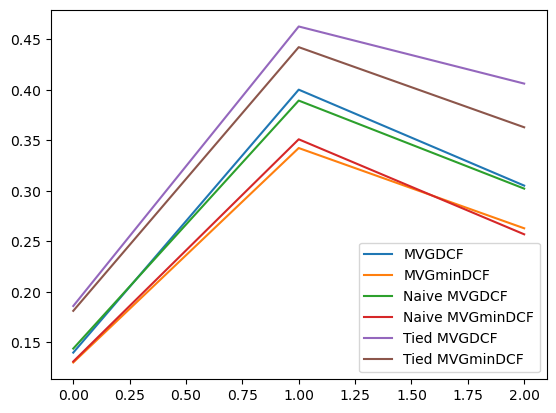

In [120]:
print(results)
for title, res in results.items():
    plt.plot(res, label=title, )
plt.legend()


MVG
Naive MVG
Tied MVG


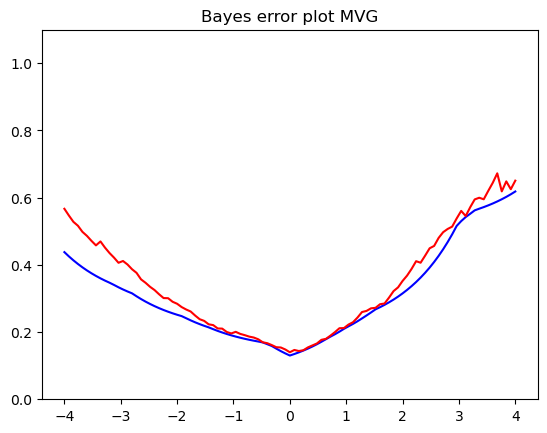

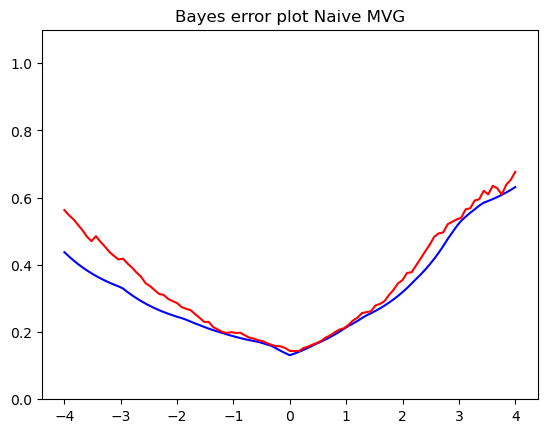

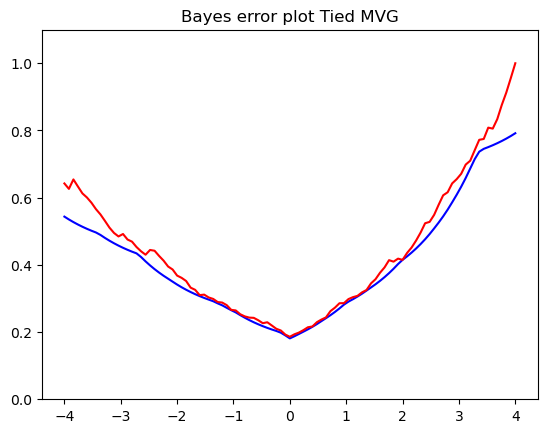

In [123]:
effPriorLogOdds = np.linspace(-4, 4, 101)
effPrior = 1/(1 + np.exp(-effPriorLogOdds))

for (strat, strat_title) in strategies:
    print(strat_title)
    ll = strat()
    llr = ll[1, :] - ll[0, :]

    dcf_with_prior = np.array([DCF(pi1, 1, 1, classify_optimally_by_bayes_cost(pi1, 1, 1, llr)) for pi1 in effPrior])
    mindcf_with_prior = np.array([minDCF(pi1, 1, 1, LVAL, llr) for pi1 in effPrior])


    plt.figure()
    plt.title("Bayes error plot " + strat_title)
    plt.plot(effPriorLogOdds, mindcf_with_prior, color='b')
    plt.plot(effPriorLogOdds, dcf_with_prior, color='r')
    plt.ylim([0, 1.1])